In [7]:
import struct
import numpy as np
import cv2
from ..phdr.data.hoda_dataset_reader import read_hoda_cdb, read_hoda_dataset


ImportError: attempted relative import with no known parent package

In [3]:
data_base_path = "../data/raw/hoda/"

print('Reading Train 60000.cdb ...')
train_images, train_labels = read_hoda_cdb(data_base_path + 'train_60k.cdb')

print('Reading Test 20000.cdb ...')
test_images, test_labels = read_hoda_cdb(data_base_path + 'test_20k.cdb')

print('Reading RemainingSamples.cdb ...')
remaining_images, remaining_labels = read_hoda_cdb(data_base_path + 'remaining_samples.cdb')


Reading Train 60000.cdb ...


NameError: name 'read_hoda_cdb' is not defined

In [12]:
print(test_labels[:5])
print(test_images[:1])


[0, 0, 0, 0, 0]
[array([[  0,   0,   0,   0,   0,   0, 255, 255,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
          0,   0,   0],
       [  0,   0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255,   0,   0],
       [  0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255,   0],
       [  0, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255],
       [  0, 255, 255, 255, 255, 255,   0,   0,   0,   0, 255, 255, 255,
        255, 255, 255],
       [255, 255, 255, 255, 255,   0,   0,   0,   0,   0,   0, 255, 255,
        255, 255, 255],
       [255, 255, 255, 255, 255,   0,   0,   0,   0,   0,   0, 255, 255,
        255, 255, 255],
       [255, 255, 255, 255, 255,   0,   0,   0,   0,   0,   0, 255, 255,
        255, 255, 255],
       [255, 255, 255, 255, 255,   0,   0,   0,   0,   0,   0, 255, 255,
        255, 255,   0],
       [  0, 

In [13]:
print(len(train_images))
print(len(test_images))


60000
20000


In [18]:
x_train = np.squeeze(train_images)
y_train = np.squeeze(train_labels)
x_test = np.squeeze(test_images)
y_test = np.squeeze(test_labels)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(60000,)
(60000,)
(20000,)
(20000,)


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [19]:
import matplotlib.pyplot as plt


label:  0


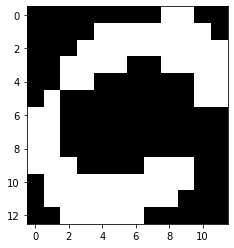

In [25]:
print("label: ", y_test[10])
plt.imshow(x_test[10], cmap="gray")
plt.show()


In [26]:
from skimage.transform import resize

# resize 5 by 5 (to reduce features)
x_train_5x5 = [resize(img, (5, 5)) for img in x_train]
x_test_5x5 = [resize(img, (5, 5)) for img in x_test]


label:  0


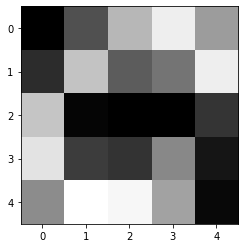

In [27]:
print("label: ", y_test[10])
plt.imshow(x_test_5x5[10], cmap="gray")
plt.show()


In [30]:
# reshape 5x5 to a vector with 25 items
x_train_5x5_feat = [x.reshape(25) for x in x_train_5x5]
x_test_5x5_feat = [x.reshape(25) for x in x_test_5x5]


In [51]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=5)
model.fit(x_train_5x5_feat, y_train)


KNeighborsClassifier()

In [53]:
sample = 1000
x_sample = [x_test_5x5_feat[sample]]
predicted_class = model.predict(x_sample)
actual_class = y_test[sample]

print(f"Sample {sample} is {actual_class} and predicted as {predicted_class}")


Sample 1000 is 0 and predicted as [0]


In [54]:
print(model.predict_proba(x_sample))


[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
